In [3]:
# prompt: install tim

!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
from torch.cuda.amp import GradScaler, autocast
import timm

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a common size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
test_dataset = AccidentDataset(data_dir + 'test', transform=transform)

# Use 20% of the dataset for training
train_size = int(0.7 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])

# DataLoaders with Reduced Batch Size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the MobileNetV2 Model (as Fast CNN)
model = timm.create_model('mobilenetv2_100', pretrained=True)

# Modify the model's head for binary classification
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.classifier.in_features, 1)
)

model = model.to(device)

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
scaler = GradScaler()

# Training, Validation, and Testing
num_epochs = 10
history_fast_cnn = {
    'train_losses': [],
    'val_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'val_accuracies': [],
    'test_accuracies': [],
}

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    history_fast_cnn['train_losses'].append(running_loss / len(train_loader))
    history_fast_cnn['train_accuracies'].append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    history_fast_cnn['val_losses'].append(val_running_loss / len(val_loader))
    history_fast_cnn['val_accuracies'].append(val_correct / len(val_loader.dataset))

    # Testing after each epoch
    test_running_loss, test_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            test_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            test_correct += (preds == labels).sum().item()

    history_fast_cnn['test_losses'].append(test_running_loss / len(test_loader))
    history_fast_cnn['test_accuracies'].append(test_correct / len(test_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {history_fast_cnn["train_losses"][-1]:.4f}, Val Loss: {history_fast_cnn["val_losses"][-1]:.4f}, Test Loss: {history_fast_cnn["test_losses"][-1]:.4f}, Train Acc: {history_fast_cnn["train_accuracies"][-1]:.4f}, Val Acc: {history_fast_cnn["val_accuracies"][-1]:.4f}, Test Acc: {history_fast_cnn["test_accuracies"][-1]:.4f}')

    scheduler.step()

# Save the model and history
model_path = f'/content/drive/MyDrive/fast_cnn_mobilenetv2_finetuned.pth'
torch.save(model.state_dict(), model_path)

history_path = f'/content/drive/MyDrive/fast_cnn_mobilenetv2_history.pth'
torch.save(history_fast_cnn, history_path)


Epoch 1/10, Train Loss: 0.5291, Val Loss: 0.3391, Test Loss: 0.4594, Train Acc: 0.7342, Val Acc: 0.8469, Test Acc: 0.7900
Epoch 2/10, Train Loss: 0.3348, Val Loss: 0.4274, Test Loss: 0.4155, Train Acc: 0.8698, Val Acc: 0.7959, Test Acc: 0.8600
Epoch 3/10, Train Loss: 0.2314, Val Loss: 0.2516, Test Loss: 0.2752, Train Acc: 0.8933, Val Acc: 0.8980, Test Acc: 0.9400
Epoch 4/10, Train Loss: 0.1518, Val Loss: 0.2032, Test Loss: 0.2046, Train Acc: 0.9584, Val Acc: 0.9184, Test Acc: 0.9400
Epoch 5/10, Train Loss: 0.0958, Val Loss: 0.1758, Test Loss: 0.1999, Train Acc: 0.9819, Val Acc: 0.9082, Test Acc: 0.9300
Epoch 6/10, Train Loss: 0.0891, Val Loss: 0.1843, Test Loss: 0.1843, Train Acc: 0.9801, Val Acc: 0.9286, Test Acc: 0.9500
Epoch 7/10, Train Loss: 0.0851, Val Loss: 0.2148, Test Loss: 0.2042, Train Acc: 0.9855, Val Acc: 0.9184, Test Acc: 0.9300
Epoch 8/10, Train Loss: 0.0918, Val Loss: 0.1716, Test Loss: 0.2040, Train Acc: 0.9765, Val Acc: 0.9082, Test Acc: 0.9300
Epoch 9/10, Train Loss: 

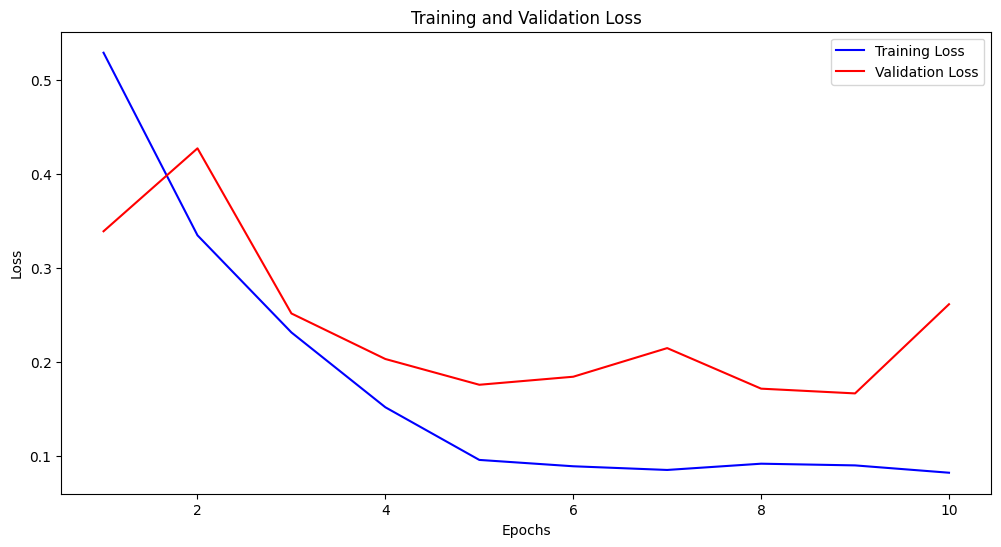

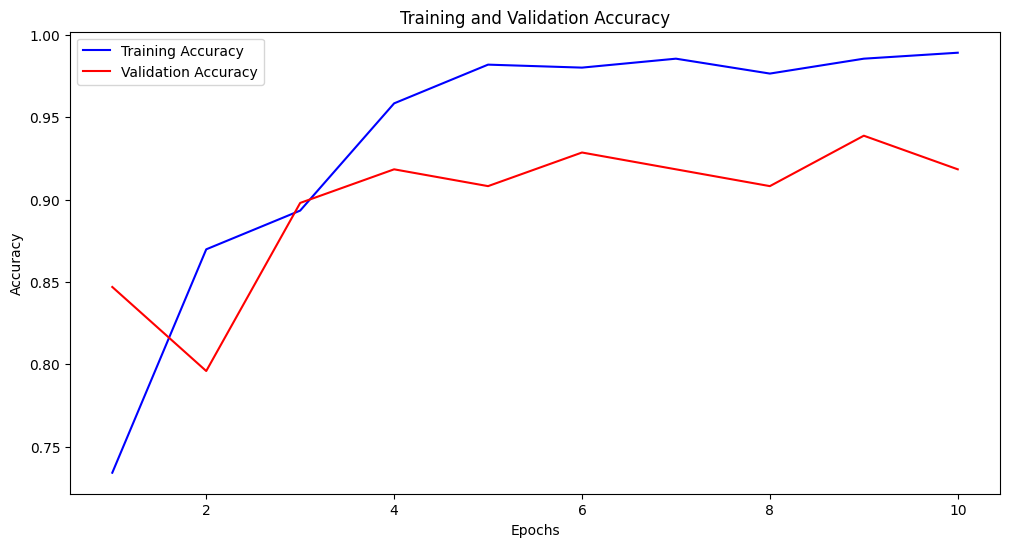

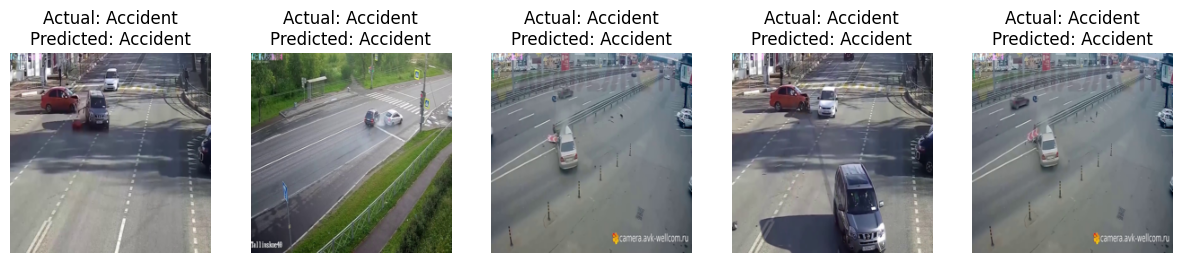

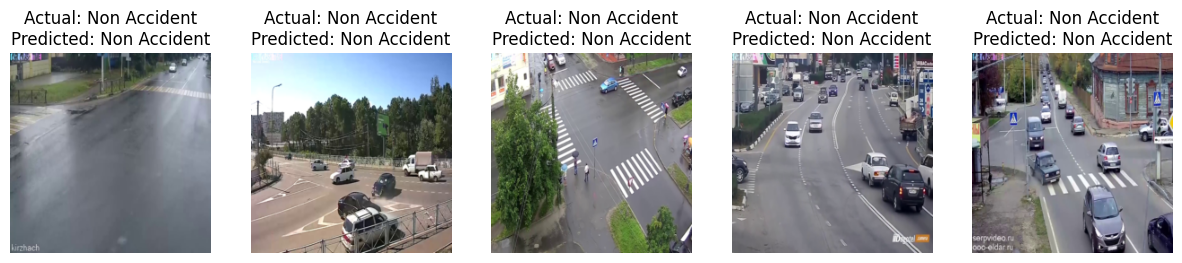

Predicted Class Distribution: [52 46]

Classification Report:
               precision    recall  f1-score   support

Non Accident       0.92      0.92      0.92        52
    Accident       0.91      0.91      0.91        46

    accuracy                           0.92        98
   macro avg       0.92      0.92      0.92        98
weighted avg       0.92      0.92      0.92        98



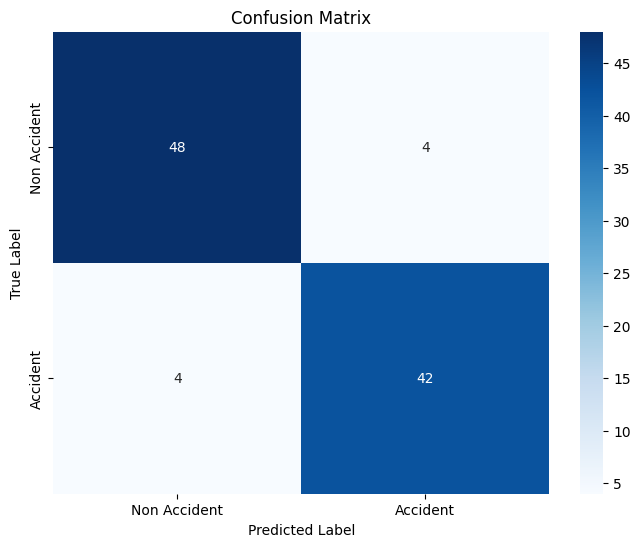

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the training history
history_path = f'/content/drive/MyDrive/fast_cnn_mobilenetv2_history.pth'
history_fast_cnn = torch.load(history_path)

# Plotting Accuracy and Loss Graphs
def plot_metrics(history):
    epochs = range(1, len(history['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_losses'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_losses'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_accuracies'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracies'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history_fast_cnn)

# Visualize Predictions on the Validation Set
def visualize_predictions(model, val_loader, num_images=5):
    model.eval()
    accident_images = []
    non_accident_images = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(preds)):
                # Collect correctly predicted accident images
                if preds[i] == 1 and labels[i] == 1 and len(accident_images) < num_images:
                    accident_images.append((inputs[i].cpu(), labels[i], preds[i]))
                # Collect correctly predicted non-accident images
                elif preds[i] == 0 and labels[i] == 0 and len(non_accident_images) < num_images:
                    non_accident_images.append((inputs[i].cpu(), labels[i], preds[i]))

                # Stop if we have enough images
                if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                    break
            if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                break

    # Plot Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Accident\nPredicted: Accident')
        plt.axis('off')
    plt.show()

    # Plot Non-Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(non_accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Non Accident\nPredicted: Non Accident')
        plt.axis('off')
    plt.show()

# Load the trained model
model_path = f'/content/drive/MyDrive/fast_cnn_mobilenetv2_finetuned.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)

# Visualize predictions
visualize_predictions(model, val_loader, num_images=5)

# Classification Report and Confusion Matrix
def generate_classification_report_and_confusion_matrix(model, val_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = (torch.sigmoid(outputs) > threshold).cpu().numpy()  # Apply threshold
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Convert predictions and labels to integers
    all_preds = np.array(all_preds).astype(int)
    all_labels = np.array(all_labels).astype(int)

    # Check the distribution of predictions
    print("Predicted Class Distribution:", np.bincount(all_preds))

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident'])
    print("\nClassification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Generate classification report and confusion matrix
generate_classification_report_and_confusion_matrix(model, val_loader)
